In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D,Input,MaxPooling2D
from tensorflow.keras.utils import to_categorical

In [3]:
import random
import time

In [4]:
path = "./germany_dataset/train.csv"
df = pd.read_csv(path)

In [5]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [6]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [37]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 32
resize_y  = 32
num_of_channels = 3
directory = "./germany_dataset/"
Epochs=5
train_length = len(df)

In [8]:
print("Total Training Examples : ",len(df))

Total Training Examples :  39209


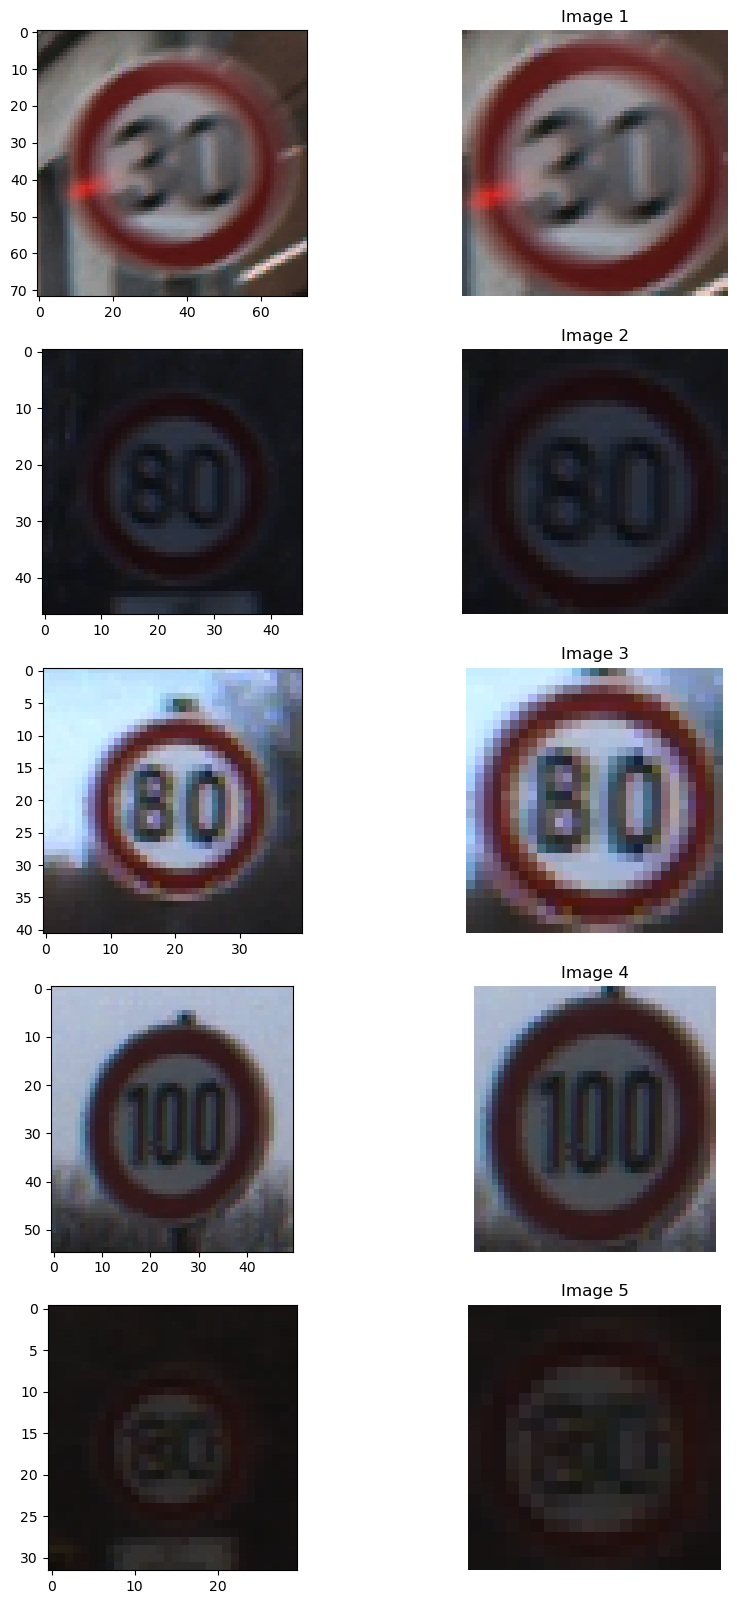

In [9]:
# Sample Images and there crop according to data given in csv
num_rows = 5
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
total_images = []
for i in range(5):
    integer = random.randint(0,train_length)
    total_images.append(df.iloc[integer].values)
total_images = list(total_images)
for i,val in enumerate(total_images):
    row = i
    col=0
    ax = axes[row, col]
    img = Image.open(directory+val[7])
    ax.imshow(img)
    img = img.crop((val[2],val[3],val[4],val[5]))
    ax = axes[row,col+1]
    ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

Total Training Examples :  39209


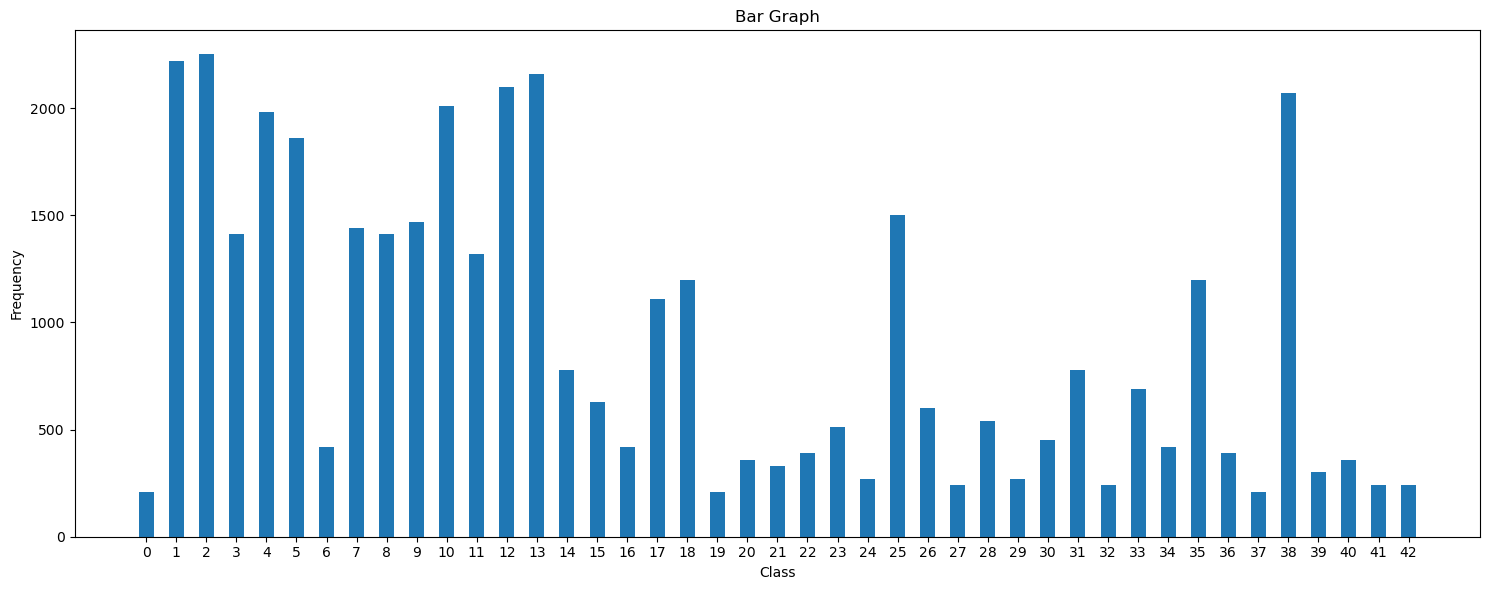

In [11]:
#Statistics of Data
print("Total Training Examples : ",len(df))
values = df["ClassId"].value_counts()
x_labels = [str(x) for x in range(num_of_classes)]
y_labels = []
for x in range(num_of_classes):
    y_labels.append(values[x])
plt.figure(figsize=(15, 6))
plt.bar(x_labels,y_labels,width=0.5)
plt.title('Bar Graph')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [15]:
# Necessary Functions

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = np.array(images)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

In [16]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = directory
        self.resize_x = size_x
        self.resize_y = size_y
    
    def Do_Crop(self,path,x1,y1,x2,y2):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        return img.resize((self.resize_x,self.resize_y))
    
    def Row_Data(self,row):
        self.X.append(self.Do_Crop(row[7],row[2],row[3],row[4],row[5]))
        self.Y.append(int(row[6]))
    
    def Get_Data(self):
        self.X = []
        self.Y = []
        for index, row in df.iterrows():
            self.Row_Data(row)

In [17]:
# Reading images from local storage
starting_time = time.time()

data = Data(df,resize_x,resize_y)
data.Get_Data()

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to read images : ",total_time," min")

Time taken to read images :  0.5426018675168355  min


In [18]:
# Up-sampling the images

starting_time = time.time()
#Storing in dictionary
classes = {}

for val in range(num_of_classes):
    classes[val]=[]

max_repeating = 0;

for i,label in enumerate(data.Y):
    classes[label].append(data.X[i])

for key in classes:
    max_repeating = max(max_repeating,len(classes[key]))

for i in range(num_of_classes):
    length = len(classes[i])
    upsample_count = max_repeating - length
    for j in range(upsample_count):
        select_image = random.randint(0,length-1)
        angle = random.randint(0,359)
        classes[i].append(classes[i][select_image].rotate(angle).resize((resize_x,resize_y)))

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to upsample images : ",total_time," min")

Time taken to upsample images :  0.04020512104034424  min


(-0.5, 31.5, 31.5, -0.5)

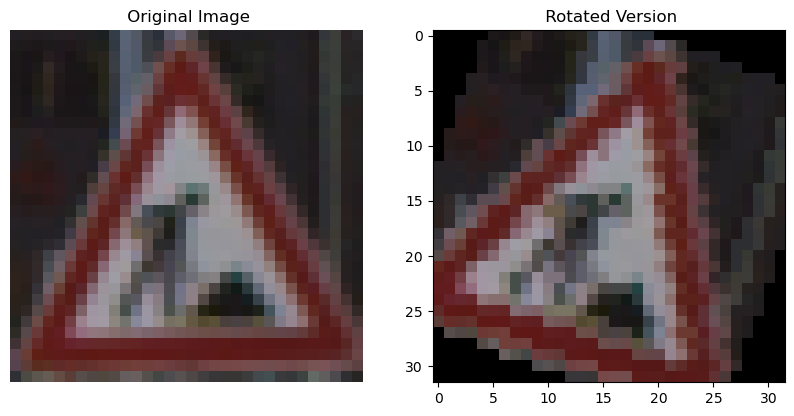

In [19]:
# Up-sampling example image

random_class = random.randint(0,num_of_classes)
length = len(classes[random_class])
random_image = random.randint(0,length-1)
img = classes[random_class][random_image]
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
ax = axes[0]
axes[0].set_title(f' Original Image')
ax.imshow(img)
angle = random.randint(1,359)
img = img.rotate(angle).resize((resize_x,resize_y))
axes[1].imshow(img)
axes[1].set_title(f' Rotated Version')
ax.axis('off')

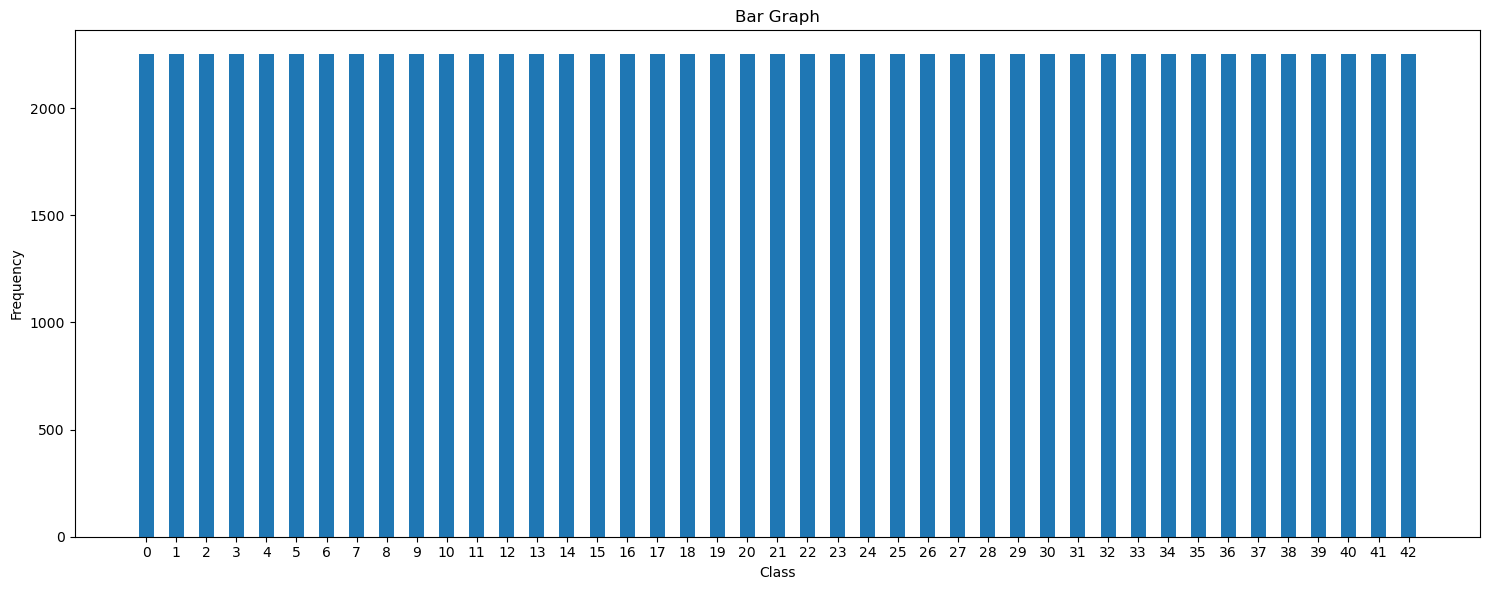

In [20]:
x_labels = [str(x) for x in range(num_of_classes)]
y_labels = []
for i in (classes):
    y_labels.append(len(classes[i]))
plt.figure(figsize=(15, 6))
plt.bar(x_labels,y_labels,width=0.5)
plt.title('Bar Graph')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [21]:
# Declaring X_train and Y_train and Re arranging the values

starting_time = time.time()

X_train = []
Y_train = []

for i in range(num_of_classes):
    for j,val in enumerate(classes[i]):
        X_train.append(np.array(val))
        Y_train.append(i)

array_pairs = list(zip(X_train, Y_train))

# Shuffle the pairs
shuffled_pairs = np.random.permutation(array_pairs)

X_train, Y_train = zip(*shuffled_pairs)

X_train = tf.convert_to_tensor(np.array(X_train),dtype=float)
Y_train = tf.convert_to_tensor(np.array(Y_train),dtype=float)


ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to convert into tensor : ",total_time," min")

C:\Users\gajul\AppData\Local\Temp\ipykernel_6672\170726535.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shuffled_pairs = np.random.permutation(array_pairs)


Time taken to convert into tensor :  0.1025366226832072  min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


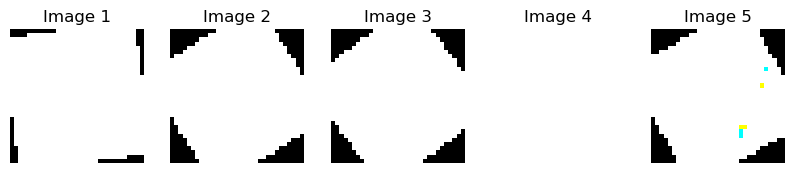

In [22]:
fig, axes = plt.subplots(1, 5, figsize=(10, 20))
length = len(X_train)
for i in range(5):
    col=i
    ax = axes[col]
    random_integer = random.randint(0,length-1)
    img = X_train[random_integer]
    ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

In [23]:
#Data_Augmentation
X_train = X_train/255.0

In [24]:
Y_train = to_categorical(Y_train)

In [30]:
_input = Input((resize_x,resize_y,num_of_channels))

In [34]:
conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(num_of_classes, activation="softmax")(dense2)

vgg16_model  = Model(inputs=_input, outputs=output)

In [35]:
vgg16_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
starting_time = time.time()

history = vgg16_model.fit(X_train,Y_train,epochs=Epochs,batch_size=1000,validation_split=0.3)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken fit : ",total_time," min")

Epoch 1/5
 9/68 [==>...........................] - ETA: 35:34 - loss: 3.7639 - accuracy: 0.0237

KeyboardInterrupt: 

In [ ]:
vgg16_model.save("VGGNET_Traffic_Sign")

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [ ]:
# vgg16_model = tf.keras.models.load_model("VGGNET_Traffic_Sign")

In [ ]:
df_test = pd.read_csv("./germany_dataset/test.csv")
print("Number of Test Images are ", len(df_test))
df_test.head()

In [ ]:
# Sample Images and there crop according to data given in test.csv
num_rows = 5
num_cols = 2
test_length = len(df_test.values)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
total_images = []
for i in range(5):
    integer = random.randint(0,test_length-1)
    total_images.append(df_test.iloc[integer].values)
total_images = list(total_images)
for i,val in enumerate(total_images):
    row = i
    col=0
    ax = axes[row, col]
    img = Image.open(directory+val[7])
    ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    img = img.crop((val[2],val[3],val[4],val[5]))
    ax = axes[row,col+1]
    ax.imshow(img)
    ax.set_title(f'Image {i + 1} [Crop]')
    ax.axis('off')

In [ ]:
# Test Images Prediction

images = []
for row in df_test.values:
    img = Image.open(directory+row[7])
    img = img.crop((row[2],row[3],row[4],row[5]))
    img = img.resize((resize_x,resize_y))
    img = np.array(img)
    images.append(img)
y_predicted = Predict_for_Multiple_examples(vgg16_model,images)

In [ ]:
# Test Accuracy Determination

y_test = df_test.iloc[:,6].values
total_correct = 0;
for i in range(test_length):
    if y_predicted[i] == y_test[i]:
        total_correct=total_correct+1
accuracy = total_correct/test_length
print("Final Test Accuracy : ",accuracy*100," %")

In [ ]:
# Testing one Random Image from test data 

select_row=random.randint(0,test_length-1)
row = df_test.iloc[select_row]
print("Original Value : ",df_test.iloc[select_row,6])
img = Image.open(directory+row[7])
img = img.crop((row[2],row[3],row[4],row[5]))
img = img.resize((resize_x,resize_y))
plt.imshow(img)
img  = np.array(img)
img  = tf.convert_to_tensor(img,dtype=float)
img = img/255.0
img = tf.expand_dims(img, axis=0)
probability = vgg16_model.predict(img)
value = get_max_index(probability[0])
print("Predicted Value : ",value)